In [2]:
import matplotlib        as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.feature   as cfeature
import cartopy.crs       as ccrs
import numpy             as np
import xarray            as xr
import pandas            as pd
import sys
import os
import netCDF4

from datetime       import datetime, timedelta
from pylab          import cm
from scipy          import ndimage


import warnings
warnings.filterwarnings("ignore")

# Defining dataset period

In [2]:
data_dir = 'pampa/poitras/DATA'
### GEM path ###
pm                   = "pm2013010100"
gemname              = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes"
ncfile_template_GEM  = "/{}/GEM5/{}/Samples_NetCDF/{}_YYYYMM/{}_YYYYMMDDd.nc".format(data_dir,gemname,gemname,pm)

### MODIS path ###
modis     = "MYD06_L2"
modisname = "NetCDF_LowMidHigh/NAM11/Cloud_Top_Pressure"
ncfile_template_MODIS = "/{}/MODIS/MYD06_L2/{}/YYYY/MYD06_L2_YYYYMMDD_hhmm.nc".format(data_dir,modisname)

### COSP path ###
ncfile_template_COSP = '/{}/COSP2/COSPOUT/{}/NAM11/M01SC002/MODIS/modis/YYYYMM/cospout_YYYYMMDDhhmm_2D.nc'.format(data_dir, gemname)

### Output directory (for figures) ###
home = "home/veilleux/Projet/Projet_SACHR/SCRIPTS/FIGURES"
dirout               = "/{}/OUTPUT/{}vsGEMvsCOSP2".format(home, modis)

##################################################################################
##################################################################################
####                                                                          ####
####              Merge filelists with common tracks                          ####
####                                                                          ####
##################################################################################
##################################################################################

YYYYi = 2014
YYYYf = 2015
YYYYMMDDi = 20140101
YYYYMMDDf = 20151231

var = 'cloud_fraction' # Select a variable 
period = 'DJF'     # Select a period (DJF,MAM,JJA,SON or ANNUAL)

# Selecting the files / timestep to treat
if   period == 'DJF'   : months = [ 1,  2, 12]
elif period == 'MAM'   : months = [ 3,  4,  5]
elif period == 'JJA'   : months = [ 6,  7,  8]
elif period == 'SON'   : months = [ 9, 10, 11]
elif period == 'ANNUAL': months = [ 1,  2,  3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
else:                    months = [ int(period) ]

# File path
filelist_2014             = "/pampa/poitras/DATA/MODIS/MYD06_L2/list/NAM11/{}.txt".format(YYYYi)
filelist_2015             = "/pampa/poitras/DATA/MODIS/MYD06_L2/list/NAM11/{}.txt".format(YYYYf)
# Loading files
df_2014          = pd.read_csv(filelist_2014,delimiter='\s+', header=None, usecols = [0,4,5,6,7])
df_2015          = pd.read_csv(filelist_2015,delimiter='\s+', header=None, usecols = [0,4,5,6,7])
# Defining columns
df_2014.columns  = ['ncfile_MODIS','date', 'month', 'date_gem', 't_gem']
df_2015.columns  = ['ncfile_MODIS','date', 'month', 'date_gem', 't_gem']
# Joining files together
df = pd.concat([df_2014, df_2015])
df = df[df['date_gem'] >= YYYYMMDDi].reset_index(drop=True)
df = df[df['date_gem'] <= YYYYMMDDf].reset_index(drop=True)
df = df[np.isin(df['month'], months)  ].reset_index(drop=True)

In [3]:
print(ncfile_template_MODIS)
print('/pampa/poitras/DATA/MODIS/MYD06_L2/NetCDF/NAM11/2014/MYD06_L2_20140101_0100.nc')

/pampa/poitras/DATA/MODIS/MYD06_L2/NetCDF_LowMidHigh/NAM11/Cloud_Top_Pressure/YYYY/MYD06_L2_YYYYMMDD_hhmm.nc
/pampa/poitras/DATA/MODIS/MYD06_L2/NetCDF/NAM11/2014/MYD06_L2_20140101_0100.nc


In [4]:
missing_value_COSP = -1.0000001e+28

test = [-1.0000001e+28,-1.0000001e+28, 12,41,50]
test_t = np.where(test == missing_value_COSP, 0, 1)
print(test_t)

1


# Getting the data and computing mean 

In [4]:
# Setting variable name, missing value and scale factor
varname_MODIS   = 'Cloud_Fraction'; 

# Retrieve field dimension
MODIS_nc   = netCDF4.Dataset(df['ncfile_MODIS'][0],'r')
MODIS_var  = MODIS_nc['Cloud_Fraction']
MODIS_dim  = MODIS_var[:].shape

### Matrices of n count per gridcell ###
n_MODIS_t    = np.zeros(MODIS_dim)
n_MODIS_h    = np.zeros(MODIS_dim)
n_MODIS_m    = np.zeros(MODIS_dim)
n_MODIS_l    = np.zeros(MODIS_dim)

n_GEM_t      = np.zeros(MODIS_dim)
n_GEM_h      = np.zeros(MODIS_dim)
n_GEM_m      = np.zeros(MODIS_dim)
n_GEM_l      = np.zeros(MODIS_dim)

n_COSP_t      = np.zeros(MODIS_dim)
n_COSP_h      = np.zeros(MODIS_dim)
n_COSP_m      = np.zeros(MODIS_dim)
n_COSP_l      = np.zeros(MODIS_dim)

### Sum of Modis data ###
data_sum_MODIS_t = np.zeros(MODIS_dim)
data_sum_MODIS_h = np.zeros(MODIS_dim)
data_sum_MODIS_m = np.zeros(MODIS_dim)
data_sum_MODIS_l = np.zeros(MODIS_dim)

data_sum_GEM_t = np.zeros(MODIS_dim)
data_sum_GEM_h = np.zeros(MODIS_dim)
data_sum_GEM_m = np.zeros(MODIS_dim)
data_sum_GEM_l = np.zeros(MODIS_dim)

data_sum_COSP_t = np.zeros(MODIS_dim)
data_sum_COSP_h = np.zeros(MODIS_dim)
data_sum_COSP_m = np.zeros(MODIS_dim)
data_sum_COSP_l = np.zeros(MODIS_dim)

for i in range(len(df['date_gem'])):
    t_gem        = df['t_gem'   ][i]
    YYYY_gem     = str(df['date_gem'][i])[0:4]
    YYYYMMDD_gem = str(df['date_gem'][i])
    YYYYMM_gem   = str(df['date_gem'][i])[0:6]
    date         = str(df['date'    ][i])
    MODIS_ncfile = df['ncfile_MODIS'][i]
    
    GEM_ncfile   = ncfile_template_GEM.replace('YYYYMMDD',YYYYMMDD_gem).replace('YYYYMM',YYYYMM_gem)
    MODIS_ncfile = ncfile_template_MODIS.replace('YYYYMMDD',str(date)[0:8]).replace('hhmm',str(date)[8:12]).replace('YYYY',str(date)[0:4])
    COSP_ncfile  = ncfile_template_COSP.replace('YYYYMMDD',str(date)[0:8]).replace('hhmm',str(date)[8:12]).replace('YYYYMM',str(date)[0:6])
    input(' ')
    print(GEM_ncfile)
    lmax         = np.max([len(MODIS_ncfile), len(GEM_ncfile)])
    strfmt       = '%-' + str(lmax) + 's'
    
    if  os.path.exists(MODIS_ncfile) and os.path.exists(GEM_ncfile) and os.path.exists(COSP_ncfile):
        
        #########################################################################
        ###                               MODIS                               ###
        #########################################################################
        ds_MODIS     = netCDF4.Dataset(MODIS_ncfile, 'r')
        ds_GEM       = netCDF4.Dataset(GEM_ncfile  , 'r')
        ds_COSP      = netCDF4.Dataset(COSP_ncfile , 'r'); 
        
        #### Data matrices ####
        data_MODIS_t      = np.array(ds_MODIS['Tot_cloud_cover'][:])
        data_MODIS_h      = np.array(ds_MODIS['High_cloud_cover'][:])
        data_MODIS_m      = np.array(ds_MODIS['Mid_cloud_cover'][:])
        data_MODIS_l      = np.array(ds_MODIS['Low_cloud_cover'][:])
        
        ### Missing Value matrices ####
        missing_value_t   = ds_MODIS['Tot_cloud_cover'].getncattr('missing_value')
        missing_value_h   = ds_MODIS['High_cloud_cover'].getncattr('missing_value')
        missing_value_m   = ds_MODIS['Mid_cloud_cover'].getncattr('missing_value')
        missing_value_l   = ds_MODIS['Low_cloud_cover'].getncattr('missing_value')
        
        ### Mask MODIS matrices ####
        mask_MODIS_t      = np.where(data_MODIS_t == missing_value_t, 0, 1)
        mask_MODIS_h      = np.where(data_MODIS_h == missing_value_h, 0, 1)
        mask_MODIS_m      = np.where(data_MODIS_m == missing_value_m, 0, 1)
        mask_MODIS_l      = np.where(data_MODIS_l == missing_value_l, 0, 1)

        data_MODIS_t      = data_MODIS_t * mask_MODIS_t
        data_MODIS_h      = data_MODIS_h * mask_MODIS_h
        data_MODIS_m      = data_MODIS_m * mask_MODIS_m
        data_MODIS_l      = data_MODIS_l * mask_MODIS_l
        
        ### Adding the matrices together ####
        n_MODIS_t         = n_MODIS_t + mask_MODIS_t             # n_Count(t) + n_Count(t + 1)...
        n_MODIS_h         = n_MODIS_h + mask_MODIS_h 
        n_MODIS_m         = n_MODIS_m + mask_MODIS_m 
        n_MODIS_l         = n_MODIS_l + mask_MODIS_l 
        
        data_sum_MODIS_t  = data_sum_MODIS_t + data_MODIS_t      # fraction(t) + fraction(t + 1)...
        data_sum_MODIS_h  = data_sum_MODIS_h + data_MODIS_h 
        data_sum_MODIS_m  = data_sum_MODIS_m + data_MODIS_m 
        data_sum_MODIS_l  = data_sum_MODIS_l + data_MODIS_l         
        
        #########################################################################
        ###                                 GEM                               ###
        #########################################################################
        data_GEM_t  = np.array(ds_GEM['TCCM'][t_gem])
        data_GEM_h  = np.array(ds_GEM['TZHM'][t_gem])
        data_GEM_m  = np.array(ds_GEM['TZMM'][t_gem])
        data_GEM_l  = np.array(ds_GEM['TZLM'][t_gem])
    
        missing_GEM_value_t   = ds_GEM['TCCM'].getncattr('_FillValue')
        missing_GEM_value_h   = ds_GEM['TZHM'].getncattr('_FillValue')
        missing_GEM_value_m   = ds_GEM['TZMM'].getncattr('_FillValue')
        missing_GEM_value_l   = ds_GEM['TZLM'].getncattr('_FillValue')
        
        GEM_mask_nocloud_t  = np.where(data_GEM_t == missing_GEM_value_t, 0, 1)
        GEM_mask_nocloud_h  = np.where(data_GEM_h == missing_GEM_value_t, 0, 1)
        GEM_mask_nocloud_m  = np.where(data_GEM_m == missing_GEM_value_t, 0, 1)
        GEM_mask_nocloud_l  = np.where(data_GEM_l == missing_GEM_value_t, 0, 1)
   
        data_GEM_t  = data_GEM_t * GEM_mask_nocloud_t 
        data_GEM_h  = data_GEM_h * GEM_mask_nocloud_h  
        data_GEM_m  = data_GEM_m * GEM_mask_nocloud_m  
        data_GEM_l  = data_GEM_l * GEM_mask_nocloud_l 
        
        ### Adding the matrices together ####
        n_GEM_t         = n_GEM_t + GEM_mask_nocloud_t     # n_Count(t) + n_Count(t + 1)...
        n_GEM_h         = n_GEM_h + GEM_mask_nocloud_h 
        n_GEM_m         = n_GEM_m + GEM_mask_nocloud_m 
        n_GEM_l         = n_GEM_l + GEM_mask_nocloud_l 
        
        data_sum_GEM_t  = data_sum_GEM_t + data_GEM_t      # fraction(t) + fraction(t + 1)...
        data_sum_GEM_h  = data_sum_GEM_h + data_GEM_h 
        data_sum_GEM_m  = data_sum_GEM_m + data_GEM_m 
        data_sum_GEM_l  = data_sum_GEM_l + data_GEM_l  
        
        #########################################################################
        ###                               COSP                                ###
        #########################################################################
        data_COSP_t = np.array(ds_COSP['cltmodis'][:].T/100)
        data_COSP_h = np.array(ds_COSP['clhmodis'][:].T/100)
        data_COSP_m = np.array(ds_COSP['clmmodis'][:].T/100)
        data_COSP_l = np.array(ds_COSP['cllmodis'][:].T/100)
        
        missing_value_COSP = -1.0000001e+28
        
        COSP_mask_t  = np.where(data_COSP_t == missing_value_COSP, 0, 1)
        COSP_mask_h  = np.where(data_COSP_h == missing_value_COSP, 0, 1)
        COSP_mask_m  = np.where(data_COSP_m == missing_value_COSP, 0, 1)
        COSP_mask_l  = np.where(data_COSP_l == missing_value_COSP, 0, 1)

        data_COSP_t = data_COSP_t * COSP_mask_t 
        data_COSP_h = data_COSP_h * COSP_mask_h
        data_COSP_m = data_COSP_m * COSP_mask_m
        data_COSP_l = data_COSP_l * COSP_mask_l
        
        ### Adding the matrices together ####
        n_COSP_t         = n_COSP_t + COSP_mask_t             # n_Count(t) + n_Count(t + 1)...
        n_COSP_h         = n_COSP_h + COSP_mask_h 
        n_COSP_m         = n_COSP_m + COSP_mask_m 
        n_COSP_l         = n_COSP_l + COSP_mask_l 
        
        data_sum_COSP_t  = data_sum_COSP_t + data_COSP_t      # fraction(t) + fraction(t + 1)...
        data_sum_COSP_h  = data_sum_COSP_h + data_COSP_h 
        data_sum_COSP_m  = data_sum_COSP_m + data_COSP_m 
        data_sum_COSP_l  = data_sum_COSP_l + data_COSP_l  
        

### Averaging for the time period choosen ###
# MODIS AVERAGES
avg_MODIS_t = data_sum_MODIS_t / n_MODIS_t  # Total cloud cover
avg_MODIS_h = data_sum_MODIS_h / n_MODIS_h  # High cloud cover
avg_MODIS_m = data_sum_MODIS_m / n_MODIS_m  # Mid cloud cover
avg_MODIS_l = data_sum_MODIS_l / n_MODIS_l  # Low cloud cover
MODIS_AVERAGE = [avg_MODIS_t, avg_MODIS_h, avg_MODIS_m, avg_MODIS_l]

#GEM AVERAGES
avg_GEM_t = data_sum_GEM_t / n_GEM_t  # Total cloud cover
avg_GEM_h = data_sum_GEM_h / n_GEM_h  # High cloud cover
avg_GEM_m = data_sum_GEM_m / n_GEM_m  # Mid cloud cover
avg_GEM_l = data_sum_GEM_l / n_GEM_l  # Low cloud cover
GEM_AVERAGE = [avg_GEM_t, avg_GEM_h, avg_GEM_m, avg_GEM_l]

#COSP AVERAGES
avg_COSP_t = data_sum_COSP_t / n_COSP_t  # Total cloud cover
avg_COSP_h = data_sum_COSP_h / n_COSP_h  # High cloud cover
avg_COSP_m = data_sum_COSP_m / n_COSP_m  # Mid cloud cover
avg_COSP_l = data_sum_COSP_l / n_COSP_l  # Low cloud cover
COSP_AVERAGE = [avg_COSP_t, avg_COSP_h, avg_COSP_m, avg_COSP_l]

 
/pampa/poitras/DATA/GEM5/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes/Samples_NetCDF/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_201401/pm2013010100_20140101d.nc
[[ 0.0000000e+00  5.0000000e-01  1.0000000e+00 ... -1.0000001e+28
  -1.0000001e+28 -1.0000001e+28]
 [ 0.0000000e+00  5.0000000e-01  1.0000000e+00 ... -1.0000001e+28
  -1.0000001e+28 -1.0000001e+28]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0000001e+28
  -1.0000001e+28 -1.0000001e+28]
 ...
 [ 1.0000000e+00  1.0000000e+00  1.0000000e+00 ... -1.0000001e+28
  -1.0000001e+28 -1.0000001e+28]
 [ 1.0000000e+00  5.0000000e-01  1.0000000e+00 ... -1.0000001e+28
  -1.0000001e+28 -1.0000001e+28]
 [ 1.0000000e+00  0.0000000e+00  1.0000000e+00 ... -1.0000001e+28
  -1.0000001e+28 -1.0000001e+28]]


KeyboardInterrupt: Interrupted by user

In [83]:
# Setting variable name, missing value and scale factor
varname_MODIS   = 'Cloud_Fraction'; 

# Retrieve field dimension
MODIS_nc   = netCDF4.Dataset(df['ncfile_MODIS'][0],'r')
MODIS_var  = MODIS_nc['Cloud_Fraction']
MODIS_dim  = MODIS_var[:].shape

### Matrices of n count per gridcell ###
n_MODIS_t    = np.zeros(MODIS_dim)
n_MODIS_h    = np.zeros(MODIS_dim)
n_MODIS_m    = np.zeros(MODIS_dim)
n_MODIS_l    = np.zeros(MODIS_dim)

n_GEM_t      = np.zeros(MODIS_dim)
n_GEM_h      = np.zeros(MODIS_dim)
n_GEM_m      = np.zeros(MODIS_dim)
n_GEM_l      = np.zeros(MODIS_dim)

n_COSP_t      = np.zeros(MODIS_dim)
n_COSP_h      = np.zeros(MODIS_dim)
n_COSP_m      = np.zeros(MODIS_dim)
n_COSP_l      = np.zeros(MODIS_dim)

### Sum of Modis data ###
data_sum_MODIS_t = np.zeros(MODIS_dim)
data_sum_MODIS_h = np.zeros(MODIS_dim)
data_sum_MODIS_m = np.zeros(MODIS_dim)
data_sum_MODIS_l = np.zeros(MODIS_dim)

data_sum_GEM_t = np.zeros(MODIS_dim)
data_sum_GEM_h = np.zeros(MODIS_dim)
data_sum_GEM_m = np.zeros(MODIS_dim)
data_sum_GEM_l = np.zeros(MODIS_dim)

data_sum_COSP_t = np.zeros(MODIS_dim)
data_sum_COSP_h = np.zeros(MODIS_dim)
data_sum_COSP_m = np.zeros(MODIS_dim)
data_sum_COSP_l = np.zeros(MODIS_dim)

for i in range(len(df['date_gem'])):
    t_gem        = df['t_gem'   ][i]
    YYYY_gem     = str(df['date_gem'][i])[0:4]
    YYYYMMDD_gem = str(df['date_gem'][i])
    YYYYMM_gem   = str(df['date_gem'][i])[0:6]
    date         = str(df['date'    ][i])
    MODIS_ncfile = df['ncfile_MODIS'][i]
    
    GEM_ncfile   = ncfile_template_GEM.replace('YYYYMMDD',YYYYMMDD_gem).replace('YYYYMM',YYYYMM_gem)
    MODIS_ncfile = ncfile_template_MODIS.replace('YYYYMMDD',str(date)[0:8]).replace('hhmm',str(date)[8:12]).replace('YYYY',str(date)[0:4])
    COSP_ncfile  = ncfile_template_COSP.replace('YYYYMMDD',str(date)[0:8]).replace('hhmm',str(date)[8:12]).replace('YYYYMM',str(date)[0:6])
     
    lmax         = np.max([len(MODIS_ncfile), len(GEM_ncfile)])
    strfmt       = '%-' + str(lmax) + 's'
    
    if  os.path.exists(MODIS_ncfile) and os.path.exists(GEM_ncfile) and os.path.exists(COSP_ncfile):
        
        #########################################################################
        ###                               MODIS                               ###
        #########################################################################
        ds_MODIS     = netCDF4.Dataset(MODIS_ncfile, 'r')
        ds_GEM       = netCDF4.Dataset(GEM_ncfile  , 'r')
        ds_COSP      = netCDF4.Dataset(COSP_ncfile , 'r'); 
        
        #### Data matrices ####
        data_MODIS_t      = np.array(ds_MODIS['Tot_cloud_cover'][:])
        data_MODIS_h      = np.array(ds_MODIS['High_cloud_cover'][:])
        data_MODIS_m      = np.array(ds_MODIS['Mid_cloud_cover'][:])
        data_MODIS_l      = np.array(ds_MODIS['Low_cloud_cover'][:])
        
        ### Missing Value matrices ####
        missing_value_t   = ds_MODIS['Tot_cloud_cover'].getncattr('missing_value')
        missing_value_h   = ds_MODIS['High_cloud_cover'].getncattr('missing_value')
        missing_value_m   = ds_MODIS['Mid_cloud_cover'].getncattr('missing_value')
        missing_value_l   = ds_MODIS['Low_cloud_cover'].getncattr('missing_value')
        
        ### Mask MODIS matrices ####
        mask_MODIS_t      = np.where(data_MODIS_t == missing_value_t, 0, 1)
        mask_MODIS_h      = np.where(data_MODIS_h == missing_value_h, 0, 1)
        mask_MODIS_m      = np.where(data_MODIS_m == missing_value_m, 0, 1)
        mask_MODIS_l      = np.where(data_MODIS_l == missing_value_l, 0, 1)
        print(missing_value_t ,missing_value_h ,missing_value_m ,missing_value_l )

        data_MODIS_t      = data_MODIS_t * mask_MODIS_t
        data_MODIS_h      = data_MODIS_h * mask_MODIS_h
        data_MODIS_m      = data_MODIS_m * mask_MODIS_m
        data_MODIS_l      = data_MODIS_l * mask_MODIS_l
        
        ### Adding the matrices together ####
        n_MODIS_t         = n_MODIS_t + mask_MODIS_t             # n_Count(t) + n_Count(t + 1)...
        n_MODIS_h         = n_MODIS_h + mask_MODIS_h 
        n_MODIS_m         = n_MODIS_m + mask_MODIS_m 
        n_MODIS_l         = n_MODIS_l + mask_MODIS_l 
        
        data_sum_MODIS_t  = data_sum_MODIS_t + data_MODIS_t      # fraction(t) + fraction(t + 1)...
        data_sum_MODIS_h  = data_sum_MODIS_h + data_MODIS_h 
        data_sum_MODIS_m  = data_sum_MODIS_m + data_MODIS_m 
        data_sum_MODIS_l  = data_sum_MODIS_l + data_MODIS_l         
        
        #########################################################################
        ###                                 GEM                               ###
        #########################################################################
        data_GEM_t  = np.array(ds_GEM['TCCM'][t_gem])
        data_GEM_h  = np.array(ds_GEM['TZHM'][t_gem])
        data_GEM_m  = np.array(ds_GEM['TZMM'][t_gem])
        data_GEM_l  = np.array(ds_GEM['TZLM'][t_gem])
    
        missing_GEM_value_t   = ds_GEM['TCCM'].getncattr('_FillValue')
        missing_GEM_value_h   = ds_GEM['TZHM'].getncattr('_FillValue')
        missing_GEM_value_m   = ds_GEM['TZMM'].getncattr('_FillValue')
        missing_GEM_value_l   = ds_GEM['TZLM'].getncattr('_FillValue')
        
        GEM_mask_nocloud_t  = np.where(data_GEM_t == missing_GEM_value_t, 0, 1)
        GEM_mask_nocloud_h  = np.where(data_GEM_h == missing_GEM_value_t, 0, 1)
        GEM_mask_nocloud_m  = np.where(data_GEM_m == missing_GEM_value_t, 0, 1)
        GEM_mask_nocloud_l  = np.where(data_GEM_l == missing_GEM_value_t, 0, 1)
   
        data_GEM_t  = data_GEM_t * GEM_mask_nocloud_t 
        data_GEM_h  = data_GEM_h * GEM_mask_nocloud_h  
        data_GEM_m  = data_GEM_m * GEM_mask_nocloud_m  
        data_GEM_l  = data_GEM_l * GEM_mask_nocloud_l 
        
        ### Adding the matrices together ####
        n_GEM_t         = n_GEM_t + GEM_mask_nocloud_t     # n_Count(t) + n_Count(t + 1)...
        n_GEM_h         = n_GEM_h + GEM_mask_nocloud_h 
        n_GEM_m         = n_GEM_m + GEM_mask_nocloud_m 
        n_GEM_l         = n_GEM_l + GEM_mask_nocloud_l 
        
        data_sum_GEM_t  = data_sum_GEM_t + data_GEM_t      # fraction(t) + fraction(t + 1)...
        data_sum_GEM_h  = data_sum_GEM_h + data_GEM_h 
        data_sum_GEM_m  = data_sum_GEM_m + data_GEM_m 
        data_sum_GEM_l  = data_sum_GEM_l + data_GEM_l  
        
        #########################################################################
        ###                               COSP                                ###
        #########################################################################
        data_COSP_t = np.array(ds_COSP['cltmodis'][:].T/100)
        data_COSP_h = np.array(ds_COSP['clhmodis'][:].T/100)
        data_COSP_m = np.array(ds_COSP['clmmodis'][:].T/100)
        data_COSP_l = np.array(ds_COSP['cllmodis'][:].T/100)
        
        missing_value_COSP = -1.0000001e+28
        
        COSP_mask_t  = np.where(data_COSP_t == missing_value_COSP, 0, 1)
        COSP_mask_h  = np.where(data_COSP_h == missing_value_COSP, 0, 1)
        COSP_mask_m  = np.where(data_COSP_m == missing_value_COSP, 0, 1)
        COSP_mask_l  = np.where(data_COSP_l == missing_value_COSP, 0, 1)
        
        data_COSP_t = data_COSP_t * COSP_mask_t 
        data_COSP_h = data_COSP_h * COSP_mask_h
        data_COSP_m = data_COSP_m * COSP_mask_m
        data_COSP_l = data_COSP_l * COSP_mask_l
        
        ### Adding the matrices together ####
        n_COSP_t         = n_COSP_t + COSP_mask_t             # n_Count(t) + n_Count(t + 1)...
        n_COSP_h         = n_COSP_h + COSP_mask_h 
        n_COSP_m         = n_COSP_m + COSP_mask_m 
        n_COSP_l         = n_COSP_l + COSP_mask_l 
        
        data_sum_COSP_t  = data_sum_COSP_t + data_COSP_t      # fraction(t) + fraction(t + 1)...
        data_sum_COSP_h  = data_sum_COSP_h + data_COSP_h 
        data_sum_COSP_m  = data_sum_COSP_m + data_COSP_m 
        data_sum_COSP_l  = data_sum_COSP_l + data_COSP_l  
        

### Averaging for the time period choosen ###
# MODIS AVERAGES
avg_MODIS_t = data_sum_MODIS_t / n_MODIS_t  # Total cloud cover
avg_MODIS_h = data_sum_MODIS_h / n_MODIS_h  # High cloud cover
avg_MODIS_m = data_sum_MODIS_m / n_MODIS_m  # Mid cloud cover
avg_MODIS_l = data_sum_MODIS_l / n_MODIS_l  # Low cloud cover
MODIS_AVERAGE = [avg_MODIS_t, avg_MODIS_h, avg_MODIS_m, avg_MODIS_l]

#GEM AVERAGES
avg_GEM_t = data_sum_GEM_t / n_GEM_t  # Total cloud cover
avg_GEM_h = data_sum_GEM_h / n_GEM_h  # High cloud cover
avg_GEM_m = data_sum_GEM_m / n_GEM_m  # Mid cloud cover
avg_GEM_l = data_sum_GEM_l / n_GEM_l  # Low cloud cover
GEM_AVERAGE = [avg_GEM_t, avg_GEM_h, avg_GEM_m, avg_GEM_l]

#COSP AVERAGES
avg_COSP_t = data_sum_COSP_t / n_COSP_t  # Total cloud cover
avg_COSP_h = data_sum_COSP_h / n_COSP_h  # High cloud cover
avg_COSP_m = data_sum_COSP_m / n_COSP_m  # Mid cloud cover
avg_COSP_l = data_sum_COSP_l / n_COSP_l  # Low cloud cover
COSP_AVERAGE = [avg_COSP_t, avg_COSP_h, avg_COSP_m, avg_COSP_l]

127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0
127.0 127.0 127.0 127.0


KeyboardInterrupt: 

# SANITARY CHECK

In [6]:
### Averaging for the time period choosen ###
# MODIS AVERAGES
avg_MODIS_t = data_sum_MODIS_t / n_MODIS_t  # Total cloud cover
avg_MODIS_h = data_sum_MODIS_h / n_MODIS_h  # High cloud cover
avg_MODIS_m = data_sum_MODIS_m / n_MODIS_m  # Mid cloud cover
avg_MODIS_l = data_sum_MODIS_l / n_MODIS_l  # Low cloud cover
MODIS_AVERAGE = [avg_MODIS_t, avg_MODIS_h, avg_MODIS_m, avg_MODIS_l]

#GEM AVERAGES
avg_GEM_t = data_sum_GEM_t / n_GEM_t  # Total cloud cover
avg_GEM_h = data_sum_GEM_h / n_GEM_h  # High cloud cover
avg_GEM_m = data_sum_GEM_m / n_GEM_m  # Mid cloud cover
avg_GEM_l = data_sum_GEM_l / n_GEM_l  # Low cloud cover
GEM_AVERAGE = [avg_GEM_t, avg_GEM_h, avg_GEM_m, avg_GEM_l]

#COSP AVERAGES
avg_COSP_t = data_sum_COSP_t / n_COSP_t  # Total cloud cover
avg_COSP_h = data_sum_COSP_h / n_COSP_t  # High cloud cover
avg_COSP_m = data_sum_COSP_m / n_COSP_t  # Mid cloud cover
avg_COSP_l = data_sum_COSP_l / n_COSP_t  # Low cloud cover
COSP_AVERAGE = [avg_COSP_t, avg_COSP_h, avg_COSP_m, avg_COSP_l]

MODIS_HML = avg_MODIS_h + avg_MODIS_m + avg_MODIS_l
check_MODIS = np.nanmean(avg_MODIS_t - MODIS_HML)
if   check_MODIS != 0: print('Sanitary Check failed, Diff = {}'.format(check_MODIS))
elif check_MODIS == 0: print('Sanitary Check failed Successful')

GEM_HML = avg_GEM_h + avg_GEM_m + avg_GEM_l
check_GEM = np.nanmean(avg_GEM_t - GEM_HML)
if   check_GEM != 0: print('Sanitary Check failed, Diff = {}'.format(check_GEM))
elif check_GEM == 0: print('Sanitary Check failed Successful')

Sanitary Check failed, Diff = -0.34435177646690884
Sanitary Check failed, Diff = -0.4355518283204259


# Bias

In [67]:
import scipy.stats
###################################
###           BIAS              ###
###################################

Bias_GEM_t  = avg_GEM_t - avg_MODIS_t
Bias_GEM_h  = avg_GEM_h - avg_MODIS_h
Bias_GEM_m  = avg_GEM_m - avg_MODIS_m
Bias_GEM_l  = avg_GEM_l - avg_MODIS_l

Bias_COSP_t = avg_COSP_t - avg_MODIS_t
Bias_COSP_h = avg_COSP_h - avg_MODIS_h
Bias_COSP_m = avg_COSP_m - avg_MODIS_m
Bias_COSP_l = avg_COSP_l - avg_MODIS_l

COR_GEM_t   = np.corrcoef(avg_MODIS_t,avg_GEM_t)

print('BIAS GEM Total : ',  np.nanmean(Bias_GEM_t)*100)
print('BIAS GEM High  : ',  np.nanmean(Bias_GEM_h)*100)
print('BIAS GEM Mid   : ',  np.nanmean(Bias_GEM_m)*100)
print('BIAS GEM Low   : ',  np.nanmean(Bias_GEM_l)*100)
print('\n')
print('BIAS COSP Total : ', np.nanmean(Bias_COSP_t)*100)
print('BIAS COSP High  : ', np.nanmean(Bias_COSP_h)*100)
print('BIAS COSP Mid   : ', np.nanmean(Bias_COSP_m)*100)
print('BIAS COSP Low   : ', np.nanmean(Bias_COSP_l)*100)

BIAS GEM Total :  -89330.33873278079
BIAS GEM High  :  -89323.42503393628
BIAS GEM Mid   :  -127350.41904825784
BIAS GEM Low   :  -162574.10205501012


BIAS COSP Total :  -89751.6392291883
BIAS COSP High  :  -89738.39763982475
BIAS COSP Mid   :  -127981.57867825418
BIAS COSP Low   :  -163406.16576423976


# RMS

In [47]:
data_DIFF_GEM  = [Bias_GEM_t , Bias_GEM_h , Bias_GEM_m , Bias_GEM_l ]
data_DIFF_COSP = [Bias_COSP_t, Bias_COSP_h, Bias_COSP_m, Bias_COSP_l]

data_RMS_GEM  = []
data_RMS_COSP = []

for i in range(4):
    sqrd_diff_GEM       = data_DIFF_GEM [i]**2 
    sqrd_diff_COSP      = data_DIFF_COSP[i]**2 

    mean_sqrd_diff_GEM  = np.nanmean(sqrd_diff_GEM ) 
    mean_sqrd_diff_COSP = np.nanmean(sqrd_diff_COSP) 

    data_RMS_GEM .append(np.sqrt(mean_sqrd_diff_GEM) )
    data_RMS_COSP.append(np.sqrt(mean_sqrd_diff_COSP))
    
print('RMS GEM Total cloud cover  : ',np.nanmean(data_RMS_GEM[0])*100 )
print('RMS GEM High cloud cover   : ',np.nanmean(data_RMS_GEM[1])*100 )
print('RMS GEM Mid cloud cover    : ',np.nanmean(data_RMS_GEM[2])*100 )
print('RMS GEM Low cloud cover    : ',np.nanmean(data_RMS_GEM[3])*100 )
print('\n')
print('RMS COSP Total cloud cover : ',np.nanmean(data_RMS_COSP[0])*100)
print('RMS COSP High cloud cover  : ',np.nanmean(data_RMS_COSP[1])*100)
print('RMS COSP Mid cloud cover   : ',np.nanmean(data_RMS_COSP[2])*100)
print('RMS COSP Low cloud cover   : ',np.nanmean(data_RMS_COSP[3])*100)

RMS GEM Total cloud cover  :  18.696177785697817
RMS GEM High cloud cover   :  12.048823276831868
RMS GEM Mid cloud cover    :  10.230742571118805
RMS GEM Low cloud cover    :  24.58749748347294


RMS COSP Total cloud cover :  18.93434549798803
RMS COSP High cloud cover  :  7.127290252292504
RMS COSP Mid cloud cover   :  15.120794630746449
RMS COSP Low cloud cover   :  39.14817479889015


# Defining the domain and grid

In [39]:
dpi = 150

# Step 0 GEM path to set lat and lon in cartopy
step_0 = "COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes_step0"
ncfile = '/{}/GEM5/{}/Samples_NetCDF/{}/pm2013010100_00000000p.nc'.format(data_dir,gemname,step_0)

# Get lat, lon and cartopy_projection_object
ds  = xr.open_dataset(ncfile) # Dataframe from the netcdf file
lat = ds.lat.values           # 2D array with latitude
lon = ds.lon.values           # 2D array with longitude
m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude, ds.rotated_pole.grid_north_pole_latitude)
xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

# MODIS vs GEM vs COSP2

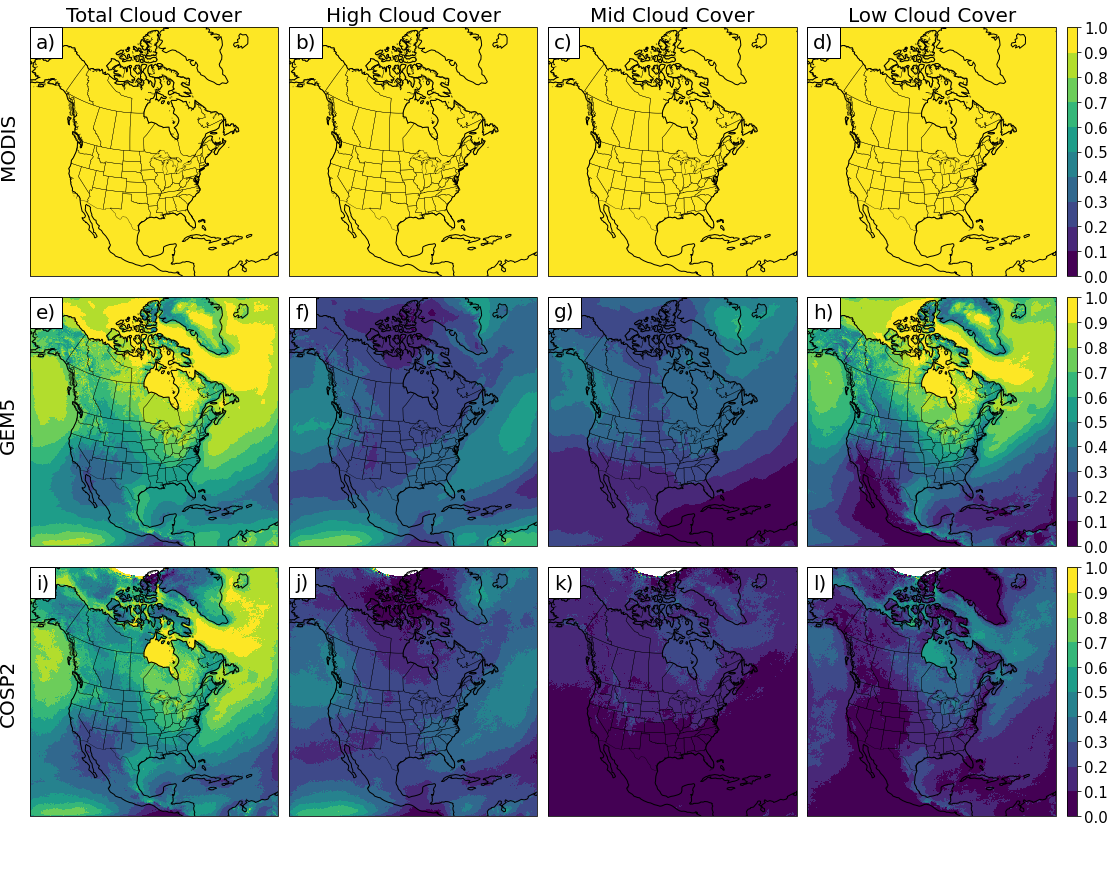

In [68]:
fig = plt.figure(figsize=(15, 15), constrained_layout = True)
vext = [0,1]
##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, cmap_maps.N)###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###                                                                                            ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cmap_maps.N)                                       ###
##########################################################################################################

L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
#############################
###        MODIS          ###
#############################

###########################################################################
l1 = 0.02; l2 = 0.26; l3 = 0.50 ;l4= 0.74                               ### 
h  = 0.23; w  = 0.23 # h = height, w = width of the subplots (fraction) ###
b  = 0.73            # b = bottom height                                ###
fs = 13              # Fontsize for titles                              ###
###########################################################################
# First subplot
ax1 = plt.axes([l1, b, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.set_title('Total Cloud Cover', fontsize = 20)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
MODIS_t = ax1.pcolormesh(lon, lat,avg_MODIS_t, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax2 = plt.axes([l2, b, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.set_title('High Cloud Cover', fontsize = 20)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,avg_MODIS_h , cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax3 = plt.axes([l3, b, w, h],projection=m)
ax3.set_extent([xll, xur, yll, yur], crs = m)
ax3.set_title('Mid Cloud Cover', fontsize = 20)
ax3.coastlines()
ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax3.pcolormesh(lon, lat,avg_MODIS_m, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax4 = plt.axes([l4, b, w, h],projection=m)
ax4.set_extent([xll, xur, yll, yur], crs = m)
ax4.set_title('Low Cloud Cover', fontsize = 20)
ax4.coastlines()
ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax4.pcolormesh(lon, lat,avg_MODIS_l, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

###########################
###         GEM5        ###
###########################
b = 0.48
# First subplot
ax5 = plt.axes([l1, b, w, h],projection=m)
ax5.set_extent([xll, xur, yll, yur], crs = m)
#ax5.set_title('Total Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax5.coastlines()
ax5.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
GEM_t = ax5.pcolormesh(lon, lat,avg_GEM_t, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax6 = plt.axes([l2, b, w, h],projection=m)
ax6.set_extent([xll, xur, yll, yur], crs = m)
#ax6.set_title('High Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax6.coastlines()
ax6.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax6.pcolormesh(lon, lat,avg_GEM_h, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax7 = plt.axes([l3, b, w, h],projection=m)
ax7.set_extent([xll, xur, yll, yur], crs = m)
#ax7.set_title('Mid Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax7.coastlines()
ax7.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax7.pcolormesh(lon, lat,avg_GEM_m, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax8 = plt.axes([l4, b, w, h],projection=m)
ax8.set_extent([xll, xur, yll, yur], crs = m)
#ax8.set_title('Low Cloud Cover \n CAL_LID_L2_05kmCPro', fontsize = 15)
ax8.coastlines()
ax8.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax8.pcolormesh(lon, lat,avg_GEM_l, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

###########################
###        COSP2        ###
###########################
b = 0.23
# First subplot
ax9 = plt.axes([l1, b, w, h],projection=m)
ax9.set_extent([xll, xur, yll, yur], crs = m)
#ax9.set_title('Total Cloud Cover \n MODIS - CALIPSO',fontsize = 15)
ax9.coastlines()
ax9.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
COSP_t = ax9.pcolormesh(lon, lat,avg_COSP_t, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax10 = plt.axes([l2, b, w, h],projection=m)
ax10.set_extent([xll, xur, yll, yur], crs = m)
#ax10.set_title('High Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax10.coastlines()
ax10.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax10.pcolormesh(lon, lat,avg_COSP_h, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax11 = plt.axes([l3, b, w, h],projection=m)
ax11.set_extent([xll, xur, yll, yur], crs = m)
#ax11.set_title('Mid Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax11.coastlines()
ax11.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax11.pcolormesh(lon, lat,avg_COSP_m, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax12 = plt.axes([l4, b, w, h],projection=m)
ax12.set_extent([xll, xur, yll, yur], crs = m)
#ax12.set_title('Low Cloud Cover \n MODIS - CALIPSO', fontsize = 15)
ax12.coastlines()
ax12.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax12.pcolormesh(lon, lat,avg_COSP_l, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

#############################
###   Colorbar setting    ###
#############################
cb_l = 0.98
#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([cb_l, 0.73, 0.01, 0.23])
cbar1    = fig.colorbar(MODIS_t, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
cbar1.ax.tick_params(labelsize=15)

cbar_ax2 = fig.add_axes([cb_l, 0.48, 0.01, 0.23])
cbar2    = fig.colorbar(GEM_t, extend = 'neither'  , cax = cbar_ax2, ticks=bounds_maps, boundaries=bounds_maps)
cbar2.ax.tick_params(labelsize=15)

cbar_ax3 = fig.add_axes([cb_l, 0.23, 0.01, 0.23])
cbar3    = fig.colorbar(COSP_t, extend = 'neither' , cax = cbar_ax3, ticks=bounds_maps, boundaries=bounds_maps)
cbar3.ax.tick_params(labelsize=15)

ax1.annotate('MODIS', xy=(-0.001, 0.8), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('GEM5' , xy=(-0.001, 0.49), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate('COSP2', xy=(-0.001, 0.18), xycoords='figure fraction', rotation = 90, fontsize=20)

x1 = 0.032; x2 = 0.2649; x3 = 0.497; x4 = 0.729
y1 = 0.945; y2 = 0.639 ;y3 = 0.332
ax1.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax3.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax4.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax5.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax6.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax7.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax8.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax9.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax10.annotate('j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax11.annotate('k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax12.annotate('l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

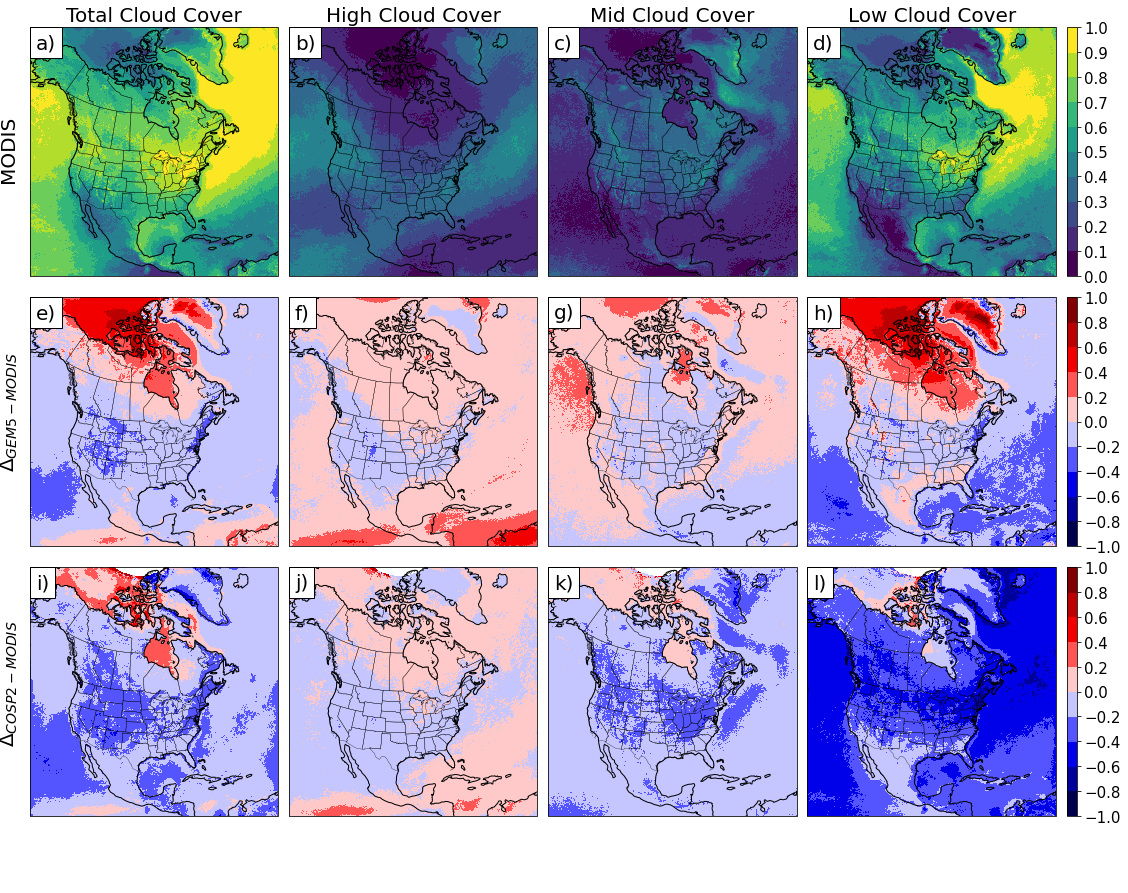

In [65]:
##########################################################################################################
###                                    Creating a discrete colorbar                                    ###
##########################################################################################################
# define the colormap                                                                                  ###
cmap_maps     = plt.cm.viridis                                                                         ###
cmap_diff     = plt.cm.seismic                                                                         ###
# extract all colors from the .jet map                                                                 ###
cmaplist_maps = [cmap_maps(i) for i in range(cmap_maps.N)]                                             ###
cmaplist_diff = [cmap_diff(i) for i in range(cmap_diff.N)]                                             ###
# Colormap                                                                                             ###
cm            = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_maps, cmap_maps.N)###
c             = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist_diff, cmap_diff.N)###
# Colobar with values from 0 to 1 with 11 discrete colors                                              ###
bounds_maps  = np.linspace(0, 1, 11)                                                                   ###
bounds_diff  = np.linspace(-1, 1, 11)                                                                  ###
                                                                                                       ###
norm_maps    = mpl.colors.BoundaryNorm(bounds_maps, cmap_maps.N)                                       ###
norm_diff    = mpl.colors.BoundaryNorm(bounds_diff, cmap_diff.N)                                       ###
##########################################################################################################

fig = plt.figure(figsize=(15, 15), constrained_layout = True)
vext     = [0,1]
vext_dif = [-1,1]
# Continental borders
L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')

#############################
###        MODIS          ###
#############################

###########################################################################
x1 = 0.02; x2 = 0.26; x3 = 0.50 ;x4= 0.74                               ###
y1 = 0.73; y2 = 0.48; y3 = 0.23  # y = bottom height                    ### 
h  = 0.23; w  = 0.23                                                    ###
# h = height, w = width of the subplots (fraction)                      ###
fs = 13              # Fontsize for titles                              ###
###########################################################################

#############################
###        MODIS          ###
#############################
# First subplot
ax1 = plt.axes([x1, y1, w, h],projection=m)
ax1.set_extent([xll, xur, yll, yur], crs = m)
ax1.set_title('Total Cloud Cover', fontsize = 20)
ax1.coastlines()
ax1.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
MODIS = ax1.pcolormesh(lon, lat,avg_MODIS_t, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Second subplot
ax2 = plt.axes([x2, y1, w, h],projection=m)
ax2.set_extent([xll, xur, yll, yur], crs = m)
ax2.set_title('High Cloud Cover', fontsize = 20)
ax2.coastlines()
ax2.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax2.pcolormesh(lon, lat,avg_MODIS_h , cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Third subplot
ax3 = plt.axes([x3, y1, w, h],projection=m)
ax3.set_extent([xll, xur, yll, yur], crs = m)
ax3.set_title('Mid Cloud Cover', fontsize = 20)
ax3.coastlines()
ax3.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax3.pcolormesh(lon, lat,avg_MODIS_m, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

# Fourth subplot
ax4 = plt.axes([x4, y1, w, h],projection=m)
ax4.set_extent([xll, xur, yll, yur], crs = m)
ax4.set_title('Low Cloud Cover', fontsize = 20)
ax4.coastlines()
ax4.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax4.pcolormesh(lon, lat,avg_MODIS_l, cmap=cm,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_maps)

#############################
###    GEM5 - MODIS       ###
#############################
# First subplot
ax5 = plt.axes([x1, y2, w, h],projection=m)
ax5.set_extent([xll, xur, yll, yur], crs = m)
ax5.coastlines()
ax5.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
GEM = ax5.pcolormesh(lon, lat,Bias_GEM_t, cmap=c,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Second subplot
ax6 = plt.axes([x2, y2, w, h],projection=m)
ax6.set_extent([xll, xur, yll, yur], crs = m)
ax6.coastlines()
ax6.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax6.pcolormesh(lon, lat,Bias_GEM_h, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Third subplot
ax7 = plt.axes([x3, y2, w, h],projection=m)
ax7.set_extent([xll, xur, yll, yur], crs = m)
ax7.coastlines()
ax7.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax7.pcolormesh(lon, lat,Bias_GEM_m, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Fourth subplot
ax8 = plt.axes([x4, y2, w, h],projection=m)
ax8.set_extent([xll, xur, yll, yur], crs = m)
ax8.coastlines()
ax8.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax8.pcolormesh(lon, lat,Bias_GEM_l, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

###########################
###   COSP2 - MODIS     ###
###########################
# First subplot
ax9 = plt.axes([x1, y3, w, h],projection=m)
ax9.set_extent([xll, xur, yll, yur], crs = m)
ax9.coastlines()
ax9.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
COSP = ax9.pcolormesh(lon, lat,Bias_COSP_t, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Second subplot
ax10 = plt.axes([x2, y3, w, h],projection=m)
ax10.set_extent([xll, xur, yll, yur], crs = m)
ax10.coastlines()
ax10.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax10.pcolormesh(lon, lat,Bias_COSP_h, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Third subplot
ax11 = plt.axes([x3, y3, w, h],projection=m)
ax11.set_extent([xll, xur, yll, yur], crs = m)
ax11.coastlines()
ax11.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax11.pcolormesh(lon, lat,Bias_COSP_m, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

# Fourth subplot
ax12 = plt.axes([x4, y3, w, h],projection=m)
ax12.set_extent([xll, xur, yll, yur], crs = m)
ax12.coastlines()
ax12.add_feature(L0_country_ALL, edgecolor='black', linewidth = 0.3)
ax12.pcolormesh(lon, lat,Bias_COSP_l, cmap=c,vmin=vext_dif[0], vmax=vext_dif[1], transform=ccrs.PlateCarree(), norm = norm_diff)

###########################
###  Adding colorbars   ###
###########################

cb_l = 0.98
#Colorbar             # [left,bottom,width,height]
cbar_ax1 = fig.add_axes([cb_l, 0.73, 0.01, 0.23])
cbar1    = fig.colorbar(MODIS, extend = 'neither', cax = cbar_ax1, ticks=bounds_maps, boundaries=bounds_maps)
cbar1.ax.tick_params(labelsize=15)

cbar_ax2 = fig.add_axes([cb_l, 0.48, 0.01, 0.23])
cbar2    = fig.colorbar(GEM  , extend = 'neither', cax = cbar_ax2, ticks=bounds_diff, boundaries=bounds_diff)
cbar2.ax.tick_params(labelsize=15)

cbar_ax3 = fig.add_axes([cb_l, 0.23, 0.01, 0.23])
cbar3    = fig.colorbar(COSP , extend = 'neither', cax = cbar_ax3, ticks=bounds_diff, boundaries=bounds_diff)
cbar3.ax.tick_params(labelsize=15)

ax1.annotate('MODIS'                  , xy=(-0.001, 0.8), xycoords='figure fraction', rotation = 90, fontsize=20)
ax5.annotate(r'$\Delta_{GEM5-MODIS}$' , xy=(-0.001, 0.478), xycoords='figure fraction', rotation = 90, fontsize=20)
ax9.annotate(r'$\Delta_{COSP2-MODIS}$', xy=(-0.001, 0.17), xycoords='figure fraction', rotation = 90, fontsize=20)

x1 = 0.032; x2 = 0.2615; x3 = 0.491; x4 = 0.721
y1 = 0.945; y2 = 0.643 ; y3 = 0.341
ax1.annotate( 'a)',  xy=(x1, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax2.annotate( 'b)',  xy=(x2, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax3.annotate( 'c)',  xy=(x3, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax4.annotate( 'd)',  xy=(x4, y1), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax5.annotate( 'e)',  xy=(x1, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax6.annotate( 'f)',  xy=(x2, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax7.annotate( 'g)',  xy=(x3, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax8.annotate( 'h)',  xy=(x4, y2), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

ax9.annotate( 'i)',  xy=(x1, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax10.annotate('j)',  xy=(x2, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax11.annotate('k)',  xy=(x3, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))
ax12.annotate('l)',  xy=(x4, y3), xycoords='figure fraction', fontsize=20, bbox=dict(boxstyle="square,pad=0.3",fc="white"))

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# MODIS, GEM5, COSP2 Bias & RMS

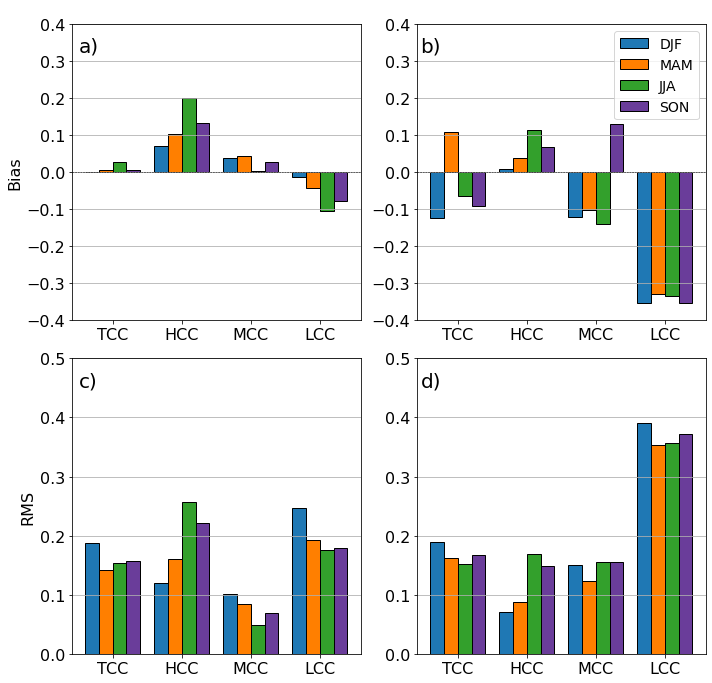

In [33]:
########################################
###              BIAS                ###
########################################

# GEM5 - MODIS
GEM5_bias_t   = [-0.02 , 0.4  , 2.6  , 0.5  ]
GEM5_bias_h   = [6.9   , 10.3 , 19.9 , 13.3 ]
GEM5_bias_m   = [3.7   , 4.2  , 0.3  , 2.6  ]
GEM5_bias_l   = [-1.5  , -4.3 , -10.7, -7.9 ]

# COSP2 - MODIS
COSP2_bias_t  = [-12.6 , 10.8 , -6.6 , -9.2 ]
COSP2_bias_h  = [0.7   , 3.8  , 11.4 , 6.7  ]
COSP2_bias_m  = [-12.2 , -10.2, -14.0, 13.1 ]
COSP2_bias_l  = [-35.6 , -33.0, -33.7, -35.4]

########################################
###               RMS                ###
########################################

# GEM5 - MODIS
GEM5_RMS_t   = [18.7  , 14.1 , 15.4 , 15.7  ]
GEM5_RMS_h   = [12.0  , 16.0 , 25.7 , 22.1  ]
GEM5_RMS_m   = [10.2  , 8.5  , 4.9  , 6.9   ]
GEM5_RMS_l   = [24.6  , 19.3 , 17.6 , 17.9  ]

# COSP2 - MODIS
COSP2_RMS_t  = [18.9 , 16.2 , 15.2  , 16.7  ]
COSP2_RMS_h  = [7.1  , 8.8  , 16.9  , 14.8  ]
COSP2_RMS_m  = [15.1 , 12.3 , 15.5  , 15.6  ]
COSP2_RMS_l  = [39.1 , 35.4 , 35.7  , 37.2  ]


seasons = ['DJF', 'MAM', 'JJA', 'SON'] # Seasons
hatches = ['#1f78b4', '#ff7f00', '#33a02c', '#6a3d9a'] # colors associated with every season for color blind readers
x_ticks = ['TCC', 'HCC', 'MCC','LCC']  # x tick labels

data_GEM5_bias  = np.array([GEM5_bias_t ,GEM5_bias_h ,GEM5_bias_m ,GEM5_bias_l ])
data_COSP2_bias = np.array([COSP2_bias_t,COSP2_bias_h,COSP2_bias_m,COSP2_bias_l])

data_GEM5_rms  = np.array([GEM5_RMS_t  ,GEM5_RMS_h ,GEM5_RMS_m ,GEM5_RMS_l ])
data_COSP2_rms = np.array([COSP2_RMS_t ,COSP2_RMS_h,COSP2_RMS_m,COSP2_RMS_l])

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

bar_width = 0.2
for i, category in enumerate(seasons):

    x_positions = np.arange(len(x_ticks)) + i * bar_width
    # Bias
    ax[0,0].bar(x_positions, data_GEM5_bias [:, i]/100, width=bar_width, label=category, color=hatches[i], edgecolor = 'k')
    ax[0,1].bar(x_positions, data_COSP2_bias[:, i]/100, width=bar_width, label=category, color=hatches[i], edgecolor = 'k')
    # RMS
    ax[1,0].bar(x_positions, data_GEM5_rms[:, i] / 100, width=bar_width, label=category, color=hatches[i], edgecolor='k')
    ax[1,1].bar(x_positions, data_COSP2_rms[:, i] / 100, width=bar_width, label=category, color=hatches[i], edgecolor='k')

# Set x tick positions and labels
for i in range(2):
    for j in range(2):
        if i == 1:
            ax[i,j].set_ylim(0,.5)
            ax[i,j].set_yticklabels(np.round(np.arange(0,.6,0.1),2),fontsize = 16)
            
        else:
            ax[i,j].set_ylim(-0.4, 0.4)
            ax[i,j].tick_params(axis='y', labelsize=16)
        # Common to all subplots
        ax[i,j].set_xticks(np.arange(len(x_ticks)) + bar_width * (len(seasons) - 1) / 2)
        ax[i,j].set_xticklabels(x_ticks,fontsize = 16)
        ax[i,j].axhline(y = 0, color='k',linewidth = 0.5,  linestyle = '--')
        ax[i,j].grid(axis = 'y')
# Add legend
ax[0,1].legend(loc = 'upper right',prop = { "size": 14 })

ax[0,0].annotate('a)', xy=(.11, .945),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[0,1].annotate('b)', xy=(.59, .945),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[1,0].annotate('c)', xy=(.11, .455),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[1,1].annotate('d)', xy=(.59, .455),
                     xycoords            ='figure fraction',
                     horizontalalignment ='left',
                     verticalalignment   ='top',
                     fontsize=20)

ax[0,0].set_ylabel('Bias',fontsize = 16)
ax[1,0].set_ylabel('RMS',fontsize = 16)

plt.tight_layout()
plt.show()

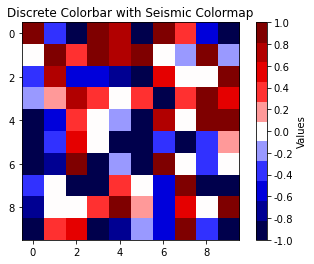